# 3. 모델 성능 평가 방법 + 피마인디언 당뇨 예측 (kaggle)

1. 정확도<br>
 -분류모형에서 정확도를 사용하지 않는 이유 <br>
2. 오차행렬
3. 정밀도와 재현율
 -정밀도/재현율의 tradeoff<br>
 -tradeoff를 이용하여 situation에 맞게 조절하는 방법(binarizer->threshold를 조정)<br>
 -정밀도와 재현율의 맹점<br>
4. F1 score
5. ROC 곡선과 AUC 곡선
 -의료부문에서 많이 쓰이는 방법이다. <br>
6. 피마 인디언 당뇨병예측 (Kaggle)

(1) **회귀** <br>
실제값과 예측값의 오차 평균값에 기반하여 평가한다. 오차의 제곱값에 루트를 씌운 후에 평균오파를 구하는 방법과 같이 예측오차를 가지고 정규화 수준을 재가공하는 방법이 회귀의 성능평가의 기초이다<br>
(2) **분류** <br>
일반적으로는 실제 결과 데이터와 예측의 결과가 얼마나 일치하는지에 대해 얼마나 정확하고 오류가 적게 발생하는지에 기반하여 작성을 하나 이 경우는 왜곡이 심할 수 있기에 따른 평가의 척도를 사용하기도 한다는 점에 주의한다.


<분류의 성능평가 지표의 정리>
- 정확도<br>
 = (예측결과가 동일한 데이터 건수) / (전체 예측 데이터 건수) <br>
 하지만 불균형 데이터 특히 이진분류 데이터에서는 결괏값이 왜곡될 가능성이 크다 <br> 
 <br>
- 오차행렬 confusion matrix. <br>
 학습분류모델이 얼마나 예측했는지, 어떻게 헷갈렸는지까지 나타내주는 matrix형태의 분류표<br>
 제1종오류, 제2종오류와 연관지어 생각할 수 있다<br>
 <br>
- 정밀도
- 재현율
- F1 score
- ROC AUC

#### 01. 정확도(Accuracy)
실제데이터에서 예측 데이터가 얼마나 같은지를 판단하는 지표. 즉 통계적으로 설명했을 때, 평균이 기준값과 거의 비슷해야 하며, sd값이 작아야 함을 의미한다(기준 값에 대해 떨어진 정도가 비슷하면 더 기준에 가까운 데이터 분포라고 설명하기 떄문이다)<br>
<br>
***정확도 = (예측결과가 동일한 데이터 건수) / (전체 예측 데이터 건수)*** <br>
하지만 이진 분류의 경우에 데이터의 구성에 따라 모델의 성능을 왜곡하기가 쉽기 때문에 정확도수치 하나만으로 정확도를 판단하기에는 왜곡이 쉽다고 본다

titanic예제에서는 여성의 생존율이 남자의 생존율보다 훨씬 높게 나왔다. 이에 대해 모델을 적용했을 때 정확도는 89%정도가 나왔다고 말할 수 있는데, 이에 대해 여성=1(생존), 남성=0(생존x)로 알고리즘을 형성하더라도, 정확도는 어느정도 높게 나올 수가 있는 왜곡된 결과를 불러올 수가 있다는 점이다. 

예1 )

In [2]:
#기본모듈 설치
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import sklearn

In [3]:
#baseestimator을 사용하여 하이퍼파라미터튜닝에 필요한 두 매서드 get_params와 set_params()를 얻으므로 생성자 사용에 도움
from sklearn.base import BaseEstimator

class MyDummyClassifier(BaseEstimator): #생성자를 구분할 필요가 없다
    #fit() 매서드는 아무것도 학습하지 않음
    def fit(self, x, y=None):
        pass
    #prediction에 해당하는 열을 구성하기 위한 method
    #prefict 매서드는 단순이 sex=1이면 0, otherwise이면 1로 예측하는 열을 구성한다
    def predict(self, X):
        pred=np.zeros((X.shape[0],1)) 
        for i in range(X.shape[0]):
            if X['Sex'].iloc[i] ==1:
                pred[i]=0
            else:
                pred[i]=1
        return pred

이제 생성된 MyDummyClassifier를 사용해 생존을 예측해봄으로써 왜곡됨을 증명해본다

In [4]:
#원본데이터 재로딩
titanic_df=pd.read_csv('train.csv')
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [5]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
#null처리 함수
def fillna(df):
    df['Age'].fillna(df['Age'].mean(), inplace=True)
    df['Cabin'].fillna('N', inplace=True)
    df['Embarked'].fillna('N', inplace=True)
    df['Fare'].fillna(0, inplace=True)
    return df

#전처리된 결과 적용
def transform_features(df):
    df=fillna(df)
    df=drop_features(df)
    df=format_features(df)
    return df

#머신러닝 알고리즘에 필요 없는 변수는 삭제
def drop_features(df):
    df.drop(['PassengerId','Name','Ticket'],axis=1, inplace=True)
    return df

#레이블 인코딩(feature scaling)
def foramt_features(df):
    df['Cabin']=df['Cabin'].str[:1]
    features=['Cabin','Sex','Embarked']
    for feature in features:
        le=LabelEncoder()
        le=le.fit(df[feature])
        df[feature]=le.transform(df[feature])
    return df

In [6]:
#앞에서 처리하고자 했던 데이터 전체 전처리
def transform_features(df):
    df=fillna(df)
    df=drop_features(df)
    df=foramt_features(df)
    return df

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

#원본데이터 재로딩, 데이터가공, 학습/테스트 데이터 분리
y_titanic_df=titanic_df['Survived'] #예측할 열 지정
x_titanic_df=titanic_df.drop('Survived',axis=1)

x_titanic_df=transform_features(x_titanic_df)
X_train, X_test, y_train, y_test=train_test_split(x_titanic_df, y_titanic_df, test_size=0.1, random_state=0)

In [8]:
#위에서 생성한 MyDummyClassifier로 예측 변수 생성하기 
myclf=MyDummyClassifier()
myclf.fit(X_train, y_train) #적용할 함수를 설정한다
mypredictions=myclf.predict(X_test)
print('dummy classifier의 정확도는:%.4f'%(accuracy_score(y_test, mypredictions)))

dummy classifier의 정확도는:0.8000


이렇게 엉성한 알고리즘으로 데이터를 평가하더라도 accuracy가 80이라는 높은 수치가 나오게 된다. **특히 불균형한 데이터일수록 '정확도'의 평가지표는 믿을 수 없다고 본다** 

예2 ) MNIST데이터 셋을 변환하여 불균형한 데이터셋을 만든 후에 정확도 지표 적용시의 왜곡을 본다. 

0~9의 값을 예측하고자 하는 데이터 셋에서 우리는 7만을 True로 반환하고자 한다. 이럴 경우에는 7을 1로 가지는 값(=true)로 인지하는 경우가 거의 없다.즉 불균등한 데이터셋을 의미한다고 본다

In [9]:
#먼저 불균형한 데이터셋과 엉성한 알고리즘 예측열을 위한 dummy classifier을 생성한다
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd

class MyFakeClassifier(BaseEstimator):
    def fit(self, X,y):
        pass
    #입력값으로 들어오는 들어오는 x데이터 셋의 크기만큼 모두 0으로 예측값을 만들어 반환한다
    def prediction(self, X):
        return np.zeros((len(X),1),dtype=bool)
#사이킷런 내장 데이터 셋인 MNIST데이터 로딩
digits=load_digits()

#digits의 번호가 7번이면 true이고 이를 astype으로 1로 변환, 7번이 아니면 false이고 0으로 반환한다
y=(digits.target==7).astype(int)
X_train, X_test, y_train, y_test = train_test_split(digits.data,y,random_state=11)

In [10]:
#참고로 digits데이터를 살펴보면 data, target,target_names, images 형태로 이루어져 있다
#이 데이터는 이미지분석을 위한 딥러닝 예로 많이 사용이 되지만
#여기서는 prediction을 위해 사용이 되었으므로 digits.target의 데이터를 사용한다
digits.target

array([0, 1, 2, ..., 8, 9, 8])

다음은 불균형한 데이터로 생성한 y_test의 분포를 확인하고 MyFakeClassifier을 이용하여 예측과 평가를 수행한다

In [11]:
#불균형한 레이블 데이터의 활용
print('레이블 테스트 데이터의 크기:',y_test.shape)
print('테스트 세트 레이블 0과 1의 분포')
print(pd.Series(y_test).value_counts) #실제 데이터에서의 value_counts를 확인, 데이터의 분포를 확인하기 위함

레이블 테스트 데이터의 크기: (450,)
테스트 세트 레이블 0과 1의 분포
<bound method IndexOpsMixin.value_counts of 0      0
1      0
2      0
3      0
4      0
5      0
6      0
7      0
8      0
9      0
10     0
11     0
12     0
13     0
14     0
15     0
16     0
17     0
18     0
19     0
20     0
21     0
22     0
23     0
24     0
25     0
26     0
27     0
28     0
29     0
      ..
420    0
421    1
422    0
423    0
424    0
425    0
426    0
427    0
428    0
429    1
430    1
431    1
432    0
433    0
434    0
435    0
436    0
437    0
438    0
439    0
440    0
441    0
442    0
443    0
444    0
445    0
446    0
447    0
448    0
449    0
Length: 450, dtype: int32>


In [12]:
#Dummy Classifier로 학습/예측/정확도 평가
fakeClf=MyFakeClassifier() #앞에서 만들어둔 모두 0으로 예측하는 데이터 셋을 의미한다
fakeClf.fit(X_train, y_train)
fakepred=fakeClf.prediction(X_test)
print('모든 예측을 0으로 하여도 정확도는 : %.3f' %(accuracy_score(y_test, fakepred)))

모든 예측을 0으로 하여도 정확도는 : 0.900


#### 2. 오차행렬 confustion Matrix
오차행렬은 **이진분류에서 성능지표로 가장 잘 활용되고 있는 학습된 분류모델이 예측을 얼마나 잘 수행하면서 얼마나 헷갈리는지를 보여주는 지표**라고 생각한다. 즉 이진분류의 예측 오류가 얼마인지와 더불어 어떠 예측의 오류가 발생하는지를 함께 보여주는 지표를 의미한다. (통계에서의 제 1종오류, 제 2종오류와 연관지어 이해가 가능하다)

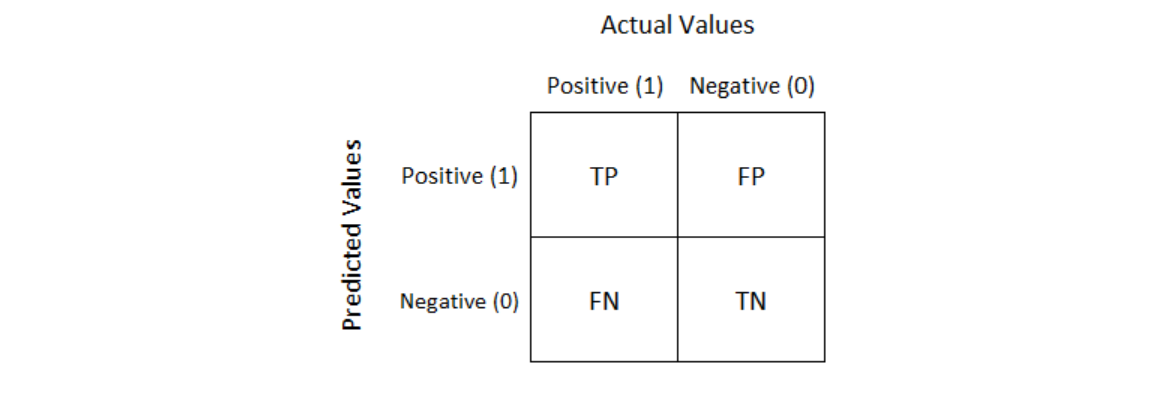

실제로 sklearn에서는 confusion_matrix() API를 제공한다. 이를 이용하여 앞에서 다뤘던 MyFakeClassifier의 예측성능을 다시 구해보고자 한다. 

In [13]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, fakepred) #실제값, 우리가 예측한 값을 넣고 오차행렬을 구한다

array([[405,   0],
       [ 45,   0]], dtype=int64)

위의 결과에 따르면 맞췄는데, 부정적으로 (즉 7이 아니라고) 판단한 경우가 405개의 데이터이고, 틀렸는데 아니라고 (즉 7인데 7이 아니라고 한 것 중에서 실제론 7인 경우가) 45개 임을 볼 수가 있다. **이 오차행렬을 가지고 정확도, 정밀도, 재현율을 모두 구해볼 수가 있다**

#### 3. 정밀도와 재현율
- **정밀도** : 예측을 positive로 한 대상 중에 실제 값이 positive로 일치한 데이터의 비율 
           '양성예측의 정확도'를 의미한다 
- **재현율** : 실제값이 positive한 대상 중에 예측과 실제 값이 positive로 일치한 데이터의 비율을 의미한다. 
           '진짜 양성율'이라고 부르기도 하며, 진짜를 진짜라고 예측했을 확률이라고 이해한다

그렇다면 정밀도를 사용해야 하는가, 재현율을 사용해야 하는가. 정밀도와 재현율 지표 중에 이진분류 모델의 업무 특성에 따라 특정평가 지표가 더 중요한 것으로 간주될 것이다. <br>

재현율이 중요한 지표가 되려면 실제 positive양성 데이터를 negative로 잘못 판단한 경우를 의미한다. 결국 재현율과 정밀도 모두 TP를 높이는데 동일하게 초점을 맞추지만 재현율은 FN을 낮추는데, 정밀도는 FP를 낮추는데 초점을 맞추게 된다. 따라서 이 두 지표는 보완적인 성향을 가지고 있다.  

정밀도 -> precision_score() <br>
재현율 -> recall_score() <br>
의 코드를 사용한다. 평가지표를 좀더 효율적으로 사용하기 위해 confusion matrix, accuracy, precision, recall을 함께 호출하는 함수를 만들어 사용하도록 한다. 

In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

def get_clf_eval(y_test, pred):
    confusion=confusion_matrix(y_test, pred) #오차행렬은 실제값, prediction값을 넣어준다
    accuracy=accuracy_score(y_test, pred) #정확도
    precision=precision_score(y_test, pred) #정밀도
    recall=recall_score(y_test, pred) #재현율
    print('오차행렬')
    print('confusion')
    print('정확도: {0:.4f},정밀도:{1:.4f}, 재현율 : {2:.4f}'.format(accuracy, precision, recall))

이제 Logistic regression을 사용하여 타이타닉 생존자를 예측하고 평가해본다

In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

#원본데이터 재로딩, 데이터 가공, 학습데이터와 테스트 데이터의 분할
titanic_df=pd.read_csv('train.csv')
y_titanic_df=titanic_df['Survived']
X_titanic_df=titanic_df.drop('Survived',axis=1)
X_titanic_df=transform_features(X_titanic_df)  #x데이터 전처리

X_train, X_test, y_train, y_test=train_test_split(X_titanic_df, y_titanic_df, test_size=0.20, random_state=11)

In [16]:
import warnings #오류무시 모듈 사용
warnings.filterwarnings('ignore')

In [17]:
lr_clf=LogisticRegression()
lr_clf.fit(X_train, y_train)
pred=lr_clf.predict(X_test)  #로지스틱 적용한 test결과
get_clf_eval(y_test, pred)   #평가지표를 사용

오차행렬
confusion
정확도: 0.8659,정밀도:0.8246, 재현율 : 0.7705


정확도는 약 90%, 정밀도 82%, 정밀도는 82%, 재현율은 77%로 재현율이 상대적으로 낮게 나왔다. 재현율 혹은 정밀도를 강화할 수 있는 방법은 무엇일까? <br>
그것은 정밀도, 재현율의 thredhold를 조정하는 방법이다. 결국 한 데이터에 대해서 구해지는 정밀도, 재현율은 거의 동일한 결과를 도출할 것이다. 이에 대해 '재현율'이 더 중요한 상황의 경우, 재현율이 더 높게 잡힐 수 있도록 thredhold를 조정하는 방향을 잡으면 될 것이다. 

### 정밀도/재현율의 tradeoff
분류하려는 업무의 특성상 정밀도 혹은 재현율이 특별히 강조되어야 할 경우에 분류의 결정 임곗값을 조정하여 정밀도 혹은 재현율의 수치를 높일 수가 있다. treshold를 조정하게 되면 정밀도 혹은 재현율 중 하나가 높아지게 되고 tradeoff관계에 의해 한쪽은 낮아지기 떄문이다. 

일반적으로 예측확률은, 그 데이터가 1 or 0이 될 확률이 50%가 넘으면 그 값이라고 잡는다.(디폴트값) 즉 threadhold를 결정하려면 개별데이터별 예측확률을 볼 필요도 있다. sklearn에서 개별 데이터별 확률을 계산해주는 함수로는 predict_proba()가 있다. 이 매서드는 학습이 완료된 sklearn classifier 객체에서 호출이 가능하며 테스트 피처데이터셋을 파라미터로 입력하면 테스트 피처 레코드의 개별 클래스 예측 확률을 반환합니다. 즉 **predict() 매서드와 유사하지만 결과가 예측결과가 아니라 예측확률의 결괏값을 반환한다는 점이 다르다.**

predict_proba()을 수행하여 반환되는 ndarray는 첫번째 칼럼이 클래스값 0에 대한 예측확률이고 두번째 칼럼이 클래스값 1에 대한 예측확률을 의미한다. 

In [18]:
pred_proba = lr_clf.predict_proba(X_test)
pred  = lr_clf.predict(X_test)
print('pred_proba()결과 Shape : {0}'.format(pred_proba.shape))
print('pred_proba array에서 앞 3개만 샘플로 추출 \n:', pred_proba[:3])

# 예측 확률 array 와 예측 결과값 array 를 concatenate 하여 예측 확률과 결과값을 한눈에 확인
pred_proba_result = np.concatenate([pred_proba , pred.reshape(-1,1)],axis=1)
print('두개의 class 중에서 더 큰 확률을 클래스 값으로 예측 \n',pred_proba_result[:3])

pred_proba()결과 Shape : (179, 2)
pred_proba array에서 앞 3개만 샘플로 추출 
: [[0.44935227 0.55064773]
 [0.86335513 0.13664487]
 [0.86429645 0.13570355]]
두개의 class 중에서 더 큰 확률을 클래스 값으로 예측 
 [[0.44935227 0.55064773 1.        ]
 [0.86335513 0.13664487 0.        ]
 [0.86429645 0.13570355 0.        ]]


사실 predict() 매서드는 predict_proba()에서부터 시작된 API이다. 결국 predict는 pred_proba에 더해, 반환결과까지 알려주는 셈이기 때문이다. 

여기서 임계값을 조절이 가능하게 해주는 모듈이 바로 Binarizer이다. 

이제는 직접 sklearn의 정밀도/재현율 트레이드오프 방식을 이해해 보는 과정의 시작이다. <br>
아래의 예체의 경우는 threshold를 특정 값으로 설정한 후에 Binarizer 클래스를 객체로 생성한다. Binarizer클래스의 fit_transform() 매서드를 이용하여 넘파이 ndarray를 입력하면 입력된 ndarray에서 지정된 threshold보다 작거나 같으면 0으로 크면 1로 반환하는 작업을 거친다

In [19]:
from sklearn.preprocessing import Binarizer

In [20]:
X=[[1,-1,2],[2,0,0],[0,1.1,1.2]] #ndarray 변수에 대한 값을 설정

#x의 개별 원소들이 threshold보다 작거나 같으면 0을, 크면 1을 반환한다
binarizer=Binarizer(threshold=1.1) #threshold를 특정값으로 설정하고, 0 or 1반환을 결정한다
print(binarizer.fit_transform(X))

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


이제는 바로 앞의 Logistic Regression을 예측할 때 predict_prob매서드로 구한 각 클래스별 예측 확률인 predict_proba에 대해 임계값을 0.5로 지정한 Binarizer 클래스를 적용하여 최종 예측값을 적용해본다

In [21]:
from sklearn.preprocessing import Binarizer

#Binarizer의 threshold 설정값, 분류결정 임계값
custom_threshold=0.5

#predict_proba() 반환값의 두번째 col 즉 positive 칼럼 하나만을 추출하여 Binarizer를 적용한다
#왜? 이 확률이 Binarizer의 custom_threshold보다 작으면 0을 예측하게 하는 것이 Binarizer의 원칙이기 때문이다. 
pred_proba_1=pred_proba[:,1].reshape(-1,1)

#Binarizer에 threshold를 적용할 데이터를 넣어줌
binarizer=Binarizer(threshold=custom_threshold).fit(pred_proba_1)
#threshold를 적용한 결과를 넣어줌
custom_predict=binarizer.transform(pred_proba_1)
#평가척도를 도출하는 함수를 출력
get_clf_eval(y_test, custom_predict)

오차행렬
confusion
정확도: 0.8659,정밀도:0.8246, 재현율 : 0.7705


50%를 threshold로 잡고 계산을 한다면 앞에서 predict로 계산한 값과 결과가 동일하게 나온다. 이에 대해 분류 임곗값을 낮추면 재현율이 올라가고 정밀도가 떨어지는 결과를 볼 수가 있습니다. 하지만 둘 중 하나의 지표도 현저히 떨어지면 안되기에 threshold를 조절해가면서 각각의 평가지표를 확인해볼 필요가 있다 

In [23]:
#테스트를 수행햘 모든 임곗값을 리스트 객체로 지정
threshold=[0.4, 0.45, 0.50, 0.55, 0.60]

def get_eval_by_threshold(y_test, pred_proba_c1, threshold):
    #thresholds list객체 내의 값을 차례대로 iteration하면서 evaluation의 진행
    for custom_threshold in threshold:
        binarizer=Binarizer(threshold=custom_threshold).fit(pred_proba_c1) #결정한 threshold를 지정
        custom_predict=binarizer.transform(pred_proba_c1)  #지정한 threshold를 적용하여 결과예측
        print('임곗값:',custom_threshold)
        get_clf_eval(y_test, custom_predict) #해당 threshold에 해당하는 평가지표 각각 출력
        print("")
        
get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1,1),threshold)

임곗값: 0.4
오차행렬
confusion
정확도: 0.8212,정밀도:0.7042, 재현율 : 0.8197

임곗값: 0.45
오차행렬
confusion
정확도: 0.8547,정밀도:0.7869, 재현율 : 0.7869

임곗값: 0.5
오차행렬
confusion
정확도: 0.8659,정밀도:0.8246, 재현율 : 0.7705

임곗값: 0.55
오차행렬
confusion
정확도: 0.8715,정밀도:0.8654, 재현율 : 0.7377

임곗값: 0.6
오차행렬
confusion
정확도: 0.8771,정밀도:0.8980, 재현율 : 0.7213



세 지표가 적절히 융화되는 구간은 임곗값이 0.45임을 알 수가 있다. 
<br>
하지만 이렇게 하지 않아도 sklearn에서는 정밀도와 재현율을 구하게 해주는 API를 가지고 있는데, 이는 precision_recall_curve()입니다. 하지만 이 API는 바로 precision과 recall을 수행해주지 않고 threshold를 지정할 인덱스를 지정해 주어 각 인덱스마다의 precision과 recall을 구하도록 만들어준다. 

In [27]:
#재현율과 정밀도를 한번에 구해주는 API작성
from sklearn.metrics import precision_recall_curve

#레이블 값이 1일 확률을 추출
pred_proba_class1=lr_clf.predict_proba(X_test)[:,1]

#실제값 데이터 셋과 레이블 값이 1일 떄의 예측확률을 precision_recall_curve인자로 입력
#precision_recall_curve의 반환값은 (정밀도, 재현율, 임계값)이 ndarray형태로 반환됨을 볼 수가 있다.
precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_class1)
print('반환되는 분류 결정 임계값의 배열 shape: ',thresholds.shape)

반환되는 분류 결정 임계값의 배열 shape:  (147,)


In [29]:
#반환된 임계값 배열 로우가 147건이므로 샘플로 10건만 추출하되 임계값을 15step을 갖도록 한다. 
thr_index=np.arange(0,thresholds.shape[0],15)
print('샘플 추출을 위한 임계값 배열의 인덱스 10개 배열:',thr_index)
print('샘플용 10개의 임계값:',np.round(thresholds[thr_index],2))

샘플 추출을 위한 임계값 배열의 인덱스 10개 배열: [  0  15  30  45  60  75  90 105 120 135]
샘플용 10개의 임계값: [0.12 0.13 0.15 0.17 0.26 0.38 0.49 0.63 0.76 0.9 ]


In [30]:
#15step 단위로 추출된 임계값에 따른 재현율과 정밀도
print('샘플 임계값별 정밀도: ', np.round(precisions[thr_index], 3))
print('샘플 임계값별 재현율: ', np.round(recalls[thr_index], 3))

샘플 임계값별 정밀도:  [0.379 0.424 0.455 0.519 0.618 0.676 0.797 0.93  0.964 1.   ]
샘플 임계값별 재현율:  [1.    0.967 0.902 0.902 0.902 0.82  0.77  0.656 0.443 0.213]


In [32]:
#재현율과 정밀도의 시각화
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

#실제데이터값과 예측확률에 대해 정확도, 정밀도 값을 그림으로 표현하고자
def precision_recall_curve_plot(y_test, pred_proba_c1):
    #treshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출
    precisions, recalls, thresholds=precision_recall_curve(y_test, pred_proba_c1)
    
    #X축을 threshold값으로, Y축을 정밀도, 재현율 값으로 각각 plot을 수행, 정밀도는 점선으로 표시한다
    plt.figure(figsize=(8,6))
    threshold_boundary=thresholds.shape[0] # 데이터를 통해 추출한 임계값을 저장
    plt.plot(thresholds, precisions[0:threshold_boundary],linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recall')
    
    #threshold 값 X축의 scale을 0.1단위로 변경
    start, end=plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2)) #x축의 범위를 변경하게하는 함수의 사용
    
    #x축, y축과 label과 범례, grid설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()
    

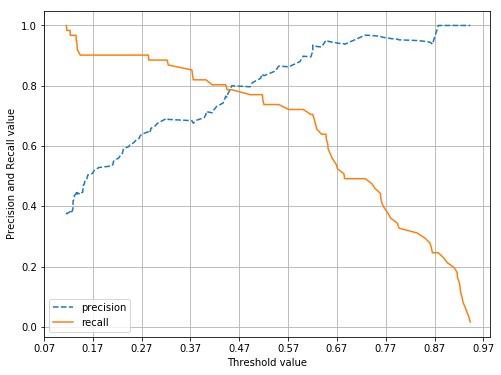

In [34]:
precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:,1])

우리는 대체적으로 임계값과 재현율이 비슷해지는 지점의 임곗값을 최선의 임계값이라고 생각하는데, 위의 시각화 결과에 따르면 0.45정도가 됨을 알 수가 있다. 정밀도와 재현율의 맹점으로는 각 지표를 100%로 만들어주면 단순히 숫자놀음에 불과한 값이 될 수밖에 없으므로, 두 값을 적절히 조합하여 최선의 임계값을 정해주는 것이 좋다고 본다. 

### 4. F1 score
Fl score는 정밀도와 재현율을 결합한 지표이다. Fl score는 정밀도와 재현율이 한쪽으로 치우치지 않는 수치를 가질 떄 상대적으로 높은 값을 가진다. 

In [35]:
from sklearn.metrics import f1_score
f1=f1_score(y_test, pred)
#어쨌든 평가지표들은 예측한 값과 실제 값에 대해 비교하는 것이므로, y_test와 pred를 비교하는 것이 맞다
print('f1 스코어: {0:.4f}'.format(f1))

f1 스코어: 0.7966


이번에는 타이타닉 생존자의 예측에서 임곗값을 변화시키면서 F1 score을 포함한 평가지표를 구해본다. 따라서 get_clf_eval()의 함수에 F1 score을 추가하는 로직을 작성한다

In [36]:
def get_clf_eval(y_test, pred):
    confusion=confusion_matrix(y_test, pred)
    accuracy=accuracy_score(y_test, pred)
    precision=precision_score(y_test, pred)
    recall=recall_score(y_test, pred)
    #F1 score 추가
    f1=f1_score(y_test, pred)
    print(confusion)
    #f1 score print도 추가한다. 
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1:{3:.4f}'.format(accuracy, precision, recall, f1))

In [43]:
thresholds=[0.4, 0.45, 0.50, 0.55, 0.60] # 임계값 설정
pred_proba=lr_clf.predict_proba(X_test) #테스트 데이터에 대하여 1이 예측될 확률을 알아보는 방법

#get_eval_by_threshold : 임곗값에 따라 평가값 get_clf_eval이 달라지게 하는 함수를 지정
get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1,1),thresholds)

임곗값: 0.4
[[97 21]
 [11 50]]
정확도: 0.8212, 정밀도: 0.7042, 재현율: 0.8197, F1:0.7576

임곗값: 0.45
[[105  13]
 [ 13  48]]
정확도: 0.8547, 정밀도: 0.7869, 재현율: 0.7869, F1:0.7869

임곗값: 0.5
[[108  10]
 [ 14  47]]
정확도: 0.8659, 정밀도: 0.8246, 재현율: 0.7705, F1:0.7966

임곗값: 0.55
[[111   7]
 [ 16  45]]
정확도: 0.8715, 정밀도: 0.8654, 재현율: 0.7377, F1:0.7965

임곗값: 0.6
[[113   5]
 [ 17  44]]
정확도: 0.8771, 정밀도: 0.8980, 재현율: 0.7213, F1:0.8000



### 05. ROC 곡선과 AUC

ROC곡선의 x축은 FPR(=false positive rate), y축은 TPR(=true positive rate)을 사용한다. 즉 FPR이 0에서 1로 증가할 때에 대한 TPR을 곡선으로 그린 형태이다. FPR을 0~1의 범위에 속하도록 만드는 방법은 임계값을 조절하는 방법이다. 왜냐하면 임계값이라는 것은 결국 어느정도 %를 넘으면 0 or 1로 예측하는 방법이기 때문에 임계값을 조절하여 FPR를 조절할 수가 있다. 

sklearn의 API인 roc_curve()를 사용이 가능하고, 반환값으로 FPR, TPR, threshold를 가진다.

In [46]:
from sklearn.metrics import roc_curve

#1임을 예측하는 확률을 pred_proba_class1에 저장
pred_proba_class1=lr_clf.predict_proba(X_test)[:,1]

fprs, tprs, thresholds=roc_curve(y_test, pred_proba_class1) #실제값과 예측확률에 대해 roc_curve를 적용한다

In [53]:
thresholds.shape

(48,)

In [51]:
#반환된 임곗값 배열의 수가 48건이므로 샘플로는 10건만 추출하되, 임곗값은 5 step으로 구성한다
thr_index=np.arange(0,thresholds.shape[0],5)
print('샘플 추출을 위한 임계값 배열의 index 10개:',thr_index)  # 5step으로 구성된 임곗값 배열의 인덱스 값
print('샘플용 10개의 임계값:',np.round(thresholds[thr_index],2)) #임곗값 중에서 5개를 인덱스값에 대해 추출

샘플 추출을 위한 임계값 배열의 index 10개: [ 0  5 10 15 20 25 30 35 40 45]
샘플용 10개의 임계값: [1.94 0.87 0.63 0.55 0.44 0.32 0.15 0.14 0.13 0.12]


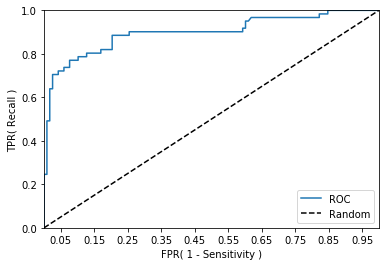

In [54]:
#ROC곡선의 시각화 
def roc_curve_plot(y_test, pred_proba_c1):
    #임계값에 다른 FPR, TPR을 반환받음
    fprs, tprs, thresholds=roc_curve(y_test, pred_proba_c1) 
    #ROC곡선을 그래프로 그림
    plt.plot(fprs, tprs, label='ROC')
    #가운데 직선 대각선을 그림(ROC의 최솟값)
    plt.plot([0,1],[0,1],'k--', label='Random')
    
    #FPR X축의 scale을 0.1단위로 변경, X,y출 명 설정 등
    # FPR X 축의 Scale을 0.1 단위로 변경, X,Y 축명 설정등   
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    plt.xlim(0,1); plt.ylim(0,1)
    plt.xlabel('FPR( 1 - Sensitivity )'); plt.ylabel('TPR( Recall )')
    plt.legend()
    plt.show()
    
roc_curve_plot(y_test, lr_clf.predict_proba(X_test)[:, 1] )

보통 ROC곡선 자체는 FPR, TPR의 변화값을 보는데 많이 사용이 된다, 따라서 분류성능의 지표로는 **AUC(Area Under Curve)** 를 많이 사용합니다. 

In [57]:
#위의 시각화한 ROC곡선을 기반으로 AUC를 구하는 방법
from sklearn.metrics import roc_auc_score

pred=lr_clf.predict(X_test)
roc_score=roc_auc_score(y_test,pred) #마찬가지로 평가지표이므로, 예측값과 실제값을 인자로 사용한다
print('ROC AUC값: {0:.4f}'.format(roc_score)) #roc를 기반으로한 auc값을 의미한다. 

ROC AUC값: 0.8429


# 피마인디언 당뇨병 예측(kaggle)

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [60]:
#클래스 결정값과 데이터의 개략적인 분포 확인
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [61]:
diabetes_data=pd.read_csv('diabetes.csv')
diabetes_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
Pregnancies                 768 non-null int64
Glucose                     768 non-null int64
BloodPressure               768 non-null int64
SkinThickness               768 non-null int64
Insulin                     768 non-null int64
BMI                         768 non-null float64
DiabetesPedigreeFunction    768 non-null float64
Age                         768 non-null int64
Outcome                     768 non-null int64
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


` info()의 결과에 따르면 NULL의 값은 없으며 feature의 type은 모두 숫자형이므로 LabelEncoder()가 필요하지 않다`

In [63]:
print(diabetes_data['Outcome'].value_counts()) #예측할 값에 대한 대략적인 분포 확인
diabetes_data.head(3) #개략적인 데이터 확인

0    500
1    268
Name: Outcome, dtype: int64


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1


이제 LogisticReg.를 활용하여 예측 모델을 생성하고 그에 대한 평가지표를 나타내보고자 한다. 

In [65]:
#festure dataset X, 레이블 데이터셋 y를 추출
#맨 끝이 Outcome 칼럼으로 레이블 값이다. 칼럼의 위치를 -1을 통해 추출해낸다
X=diabetes_data.iloc[:,:-1]
y=diabetes_data.iloc[:,-1]

In [66]:
#test data와 train data의 분할과정(모델을 적용하여 평가해보기 위한 필수지표)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=156, stratify=y)

In [67]:
#로지스틱 회귀로 학습, 예측 및 평가 수행
lr_clf=LogisticRegression() #로시스틱회귀를 사용하기 위한 객체를 먼저 지정한다
lr_clf.fit(X_train, y_train) #학습x. 어떤 식으로 회귀를 진행할 것인지에 대해 알려준다.
pred=lr_clf.predict(X_test)
get_clf_eval(y_test, pred) #평가지표의 출력

[[87 13]
 [22 32]]
정확도: 0.7727, 정밀도: 0.7111, 재현율: 0.5926, F1:0.6465


`위에서 OutCome의 value_counts를 사용한 결과, negative의 값이 많았으므로 정확도보다는 재현율에 초점을 맞춰 진행을 하는 것이 맞다고 본다. 따라서 임계값 별 재현율과 정밀도를 예측하기 위해 precision_recall_curve_plot()을 그려 확인한다. 
결국 예측하고자 하는 데이터의 분포에 따라서 사용하게되는 평가의 지표가 달라진다고 볼 수가 있다`

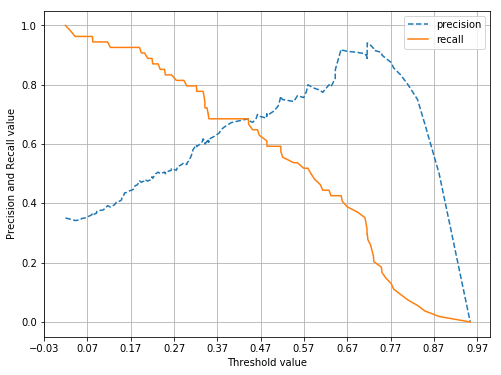

In [71]:
pred_proba_c1=lr_clf.predict_proba(X_test)[:,1] #1의 값이 예측될 확률
precision_recall_curve_plot(y_test, pred_proba_c1) #테스트, 예측값을 인자로 입력하여 ROC, AUC곡선 그린다

재현율 곡선을 보면 임곗값을 0.42정도로 낮춰야 정밀도와 재현율이 어느정도 균형을 맞출수 있으므로, 임곗값을 설정한다면 0.42로 잡아주어야 한다. 하지만 그렇게 되면 두 지표 모두 0.7이 안되는 수치이므로 여전히 두 지표의 값이 모두 낮다. 따라서 데이터 값을 먼저 점검해야 한다. 

In [73]:
diabetes_data.describe() #개괄적인 기초통계량 확인

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


위의 데이터 feature값을 확인하면 Glucoser값에 최솟값이 0으로 지정된 것을 볼 수가 있는데, Glucose는 포도당 수치를 의미하므로 min값이 0이 되는것은 사실상 말이 되지 않는 데이터값이라는 것을 알 수가 있다. 

(array([  5.,   0.,   4.,  32., 156., 211., 163.,  95.,  56.,  46.]),
 array([  0. ,  19.9,  39.8,  59.7,  79.6,  99.5, 119.4, 139.3, 159.2,
        179.1, 199. ]),
 <a list of 10 Patch objects>)

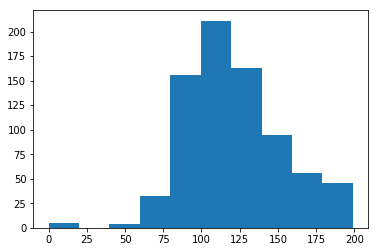

In [75]:
plt.hist(diabetes_data['Glucose'],bins=10)
# 전체 데이터에 대해 0의 비율이 꽤 많은 것으로 보인다. 

Glucoser 데이터 뿐 아니라 min()값이 0으로 되어있는 feature에 대해 0의 값이 몇 퍼센트 인지를 확인해보아야 한다. 

In [83]:
#0값을 검사할 피처명 리스트(ID와 같은 데이터는 제외하고, 검사할 수 있는 데이터를 넣는다)
zero_features=['Glucose','BloodPressure','SkinThickness','Insulin','BMI']

#전체 데이터 건수
total_count=diabetes_data['Glucose'].count()

#피처별로 반복하면서 데이터 값이 0인 데이터 건수를 추출하고 0인 퍼센트를 계산한다
for feature in zero_features:
    zero_count=diabetes_data[diabetes_data[feature]==0][feature].count()
    print('{0} 0 건수는 {1}, 퍼센트는 {2:.2f} %'.format(feature, zero_count, 100*zero_count/total_count))

Glucose 0 건수는 5, 퍼센트는 0.65 %
BloodPressure 0 건수는 35, 퍼센트는 4.56 %
SkinThickness 0 건수는 227, 퍼센트는 29.56 %
Insulin 0 건수는 374, 퍼센트는 48.70 %
BMI 0 건수는 11, 퍼센트는 1.43 %


SkinThickness ,Insulin feature에서의 0의 비율은 매우 높다. 따라서 0으로 대체하면 제대로된 분석이 어려울 것 같아, 평균값으로 대체합니다.

In [85]:
#zero_features 리스트 내부에 저장된 개별 feature들에 대해서 0값을 평균 값으로 대체한다
mean_zero_features=diabetes_data[zero_features].mean()
diabetes_data[zero_features]=diabetes_data[zero_features].replace(0,mean_zero_features)

0값으로 대체한 데이터셋에 피처스케일링을 적용해 변환한다. 로지스틱 회귀의 경우, 일반적으로 숫자데이터에 feature scaling을 적용하는 것이 좋기 때문이다.

In [86]:
#변경된 데이터셋에 대해 새롭게 x,y값의 지정
X=diabetes_data.iloc[:,:-1]
y=diabetes_data.iloc[:,-1]

In [88]:
#Standard Scaler를 사용하여 피처 스케일링 데이터 셋에 일괄적으로 스케일링을 적용한다
scaler=StandardScaler()
X_scaled=scaler.fit_transform(X)

#변경된 데이터 셋 기반으로 다시 데이터 split
X_train, X_test, y_train, y_test=train_test_split(X_scaled, y, test_size=0.2, random_state=156, stratify=y)

In [89]:
#로지스틱 회귀로 학습, 예측 및 평가 수행
lr_clf=LogisticRegression() #로지스틱을 적용하기 위한 객체의 생성
lr_clf.fit(X_train, y_train) #적용하고자 하는 함수의 형태 마련
pred=lr_clf.predict(X_test)  #예측값 지정
get_clf_eval(y_test,pred)    #평가지표의 출력

[[90 10]
 [21 33]]
정확도: 0.7987, 정밀도: 0.7674, 재현율: 0.6111, F1:0.6804


전체적인 데이터의 기초통계량을 확인하여 결손데이터를 처리했는데도 불구하고, 재현율이 그렇게 높아지지 못했다. 이 문제에서는 재현율을 높이는 것이 중요한 목표가 될 예정이기 때문에 임계값을 지정하여 변화하는 값을 관찰해보도록 한다. 

In [91]:
thresholds=[0.3, 0.33, 0.36, 0.39, 0.42, 0.45, 0.48, 0.50] #임계값을 지정
pred_proba=lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1,1),thresholds)

임곗값: 0.3
[[65 35]
 [11 43]]
정확도: 0.7013, 정밀도: 0.5513, 재현율: 0.7963, F1:0.6515

임곗값: 0.33
[[71 29]
 [11 43]]
정확도: 0.7403, 정밀도: 0.5972, 재현율: 0.7963, F1:0.6825

임곗값: 0.36
[[76 24]
 [15 39]]
정확도: 0.7468, 정밀도: 0.6190, 재현율: 0.7222, F1:0.6667

임곗값: 0.39
[[78 22]
 [16 38]]
정확도: 0.7532, 정밀도: 0.6333, 재현율: 0.7037, F1:0.6667

임곗값: 0.42
[[84 16]
 [18 36]]
정확도: 0.7792, 정밀도: 0.6923, 재현율: 0.6667, F1:0.6792

임곗값: 0.45
[[85 15]
 [18 36]]
정확도: 0.7857, 정밀도: 0.7059, 재현율: 0.6667, F1:0.6857

임곗값: 0.48
[[88 12]
 [19 35]]
정확도: 0.7987, 정밀도: 0.7447, 재현율: 0.6481, F1:0.6931

임곗값: 0.5
[[90 10]
 [21 33]]
정확도: 0.7987, 정밀도: 0.7674, 재현율: 0.6111, F1:0.6804



위의 결과를 확인하면 정밀도를 희생하고 재현율을 높이는데 가장 좋은 임계값은 0.33으로 보인다, 하지만 이 경우에는 정밀도가 59%이므로 매우 극단적인 값을 가진다. 따라서 재현율, 정밀도를 적절히 고려하여 임계값을 0.48로 잡는 것이 가장 적당해 보인다. <br>
이 임계값을 사용하여 다시 평가지표를 출력해본다. 임계값을 조절하고자 하는 모듈을 Binarizer이므로 이것을 사용한다

In [92]:
#임계값을 0.48로 설정한 Binarizer 생성
binarizer=Binarizer(threshold=0.48) #임계값을 특정 값으로 custom

pred_th_048=binarizer.fit_transform(pred_proba[:,1].reshape(-1,1))
get_clf_eval(y_test, pred_th_048)

[[88 12]
 [19 35]]
정확도: 0.7987, 정밀도: 0.7447, 재현율: 0.6481, F1:0.6931
